# FOOOF - Tutorial

FOOOF (fitting oscillations & one over f) is a module to fit neural power spectra.  


In [1]:
%matplotlib inline
import numpy as np

# Temporary path BS to add FOOOF module to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
# Import the FOOOF object
from fooof import FOOOF

In [3]:
# Load example data
freqs = np.load('freqs.npy')
psd = np.load('linear_psd.npy')

In [4]:
# Initialize FOOOF model, and set frequency range to use
fm = FOOOF()
freq_range = [3, 40]

### FOOOF.model( ) vs. FOOOF.fit()

There are 2 main ways to fit the PSD model with FOOOF. Each method calls the same underlying fitting procedure, the only difference being what is printed out to the console.

- FOOOF.model( ) fits the PSD model, then plots the PSD & model, and prints out the model parameters. 
- FOOOF.fit( ) just fits the model,


FOOOF WARNING: Lower-bound Bandwidth limit is ~= the frequency resolution. 
   This may lead to overfitting of small bandwidth oscillations.


                                          FOOOF - PSD MODEL                                          

                      The input PSD was modeled in the frequency range 3-40 Hz                      
                                 Frequency Resolution is 0.49 Hz 
                                  
                       Background Parameters (offset, slope, and curvature):                        
                                    -21.8243, -0.8088, 2.58e-24                                     

                                      4 oscillations were found:                                     
                                 CF:   9.76, Amp:  1.086, BW:  2.16                                 
                                 CF:  13.47, Amp:  0.217, BW:  1.74                                 
                                 CF:  15.92,

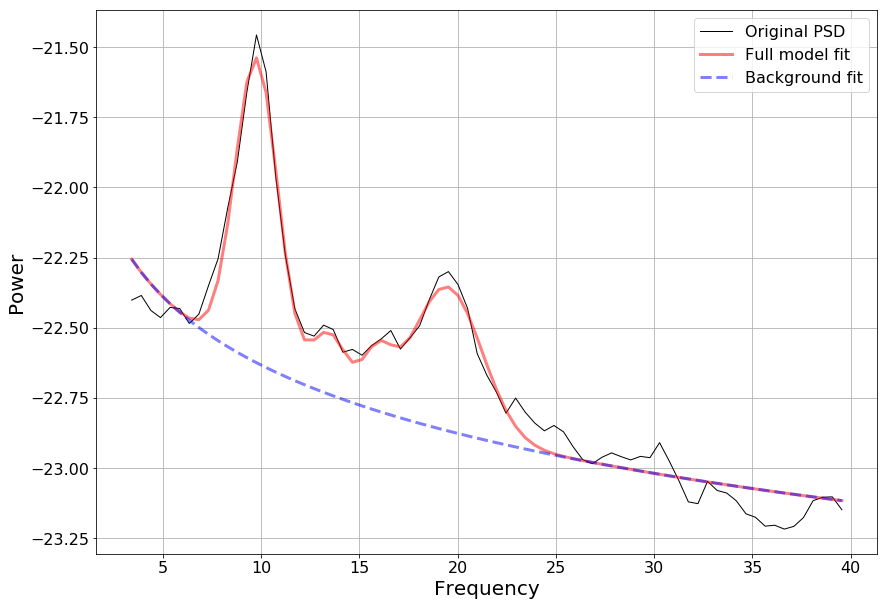

In [5]:
# Run FOOOF model - calculates model, plots, and prints parameters
fm.model(freqs, psd, freq_range)


FOOOF WARNING: Lower-bound Bandwidth limit is ~= the frequency resolution. 
   This may lead to overfitting of small bandwidth oscillations.


                                          FOOOF - PSD MODEL                                          

                      The input PSD was modeled in the frequency range 3-40 Hz                      
                               (ignoring the values on [12, 17] Hz) 
                               
                                 Frequency Resolution is 0.49 Hz 
                                  
                       Background Parameters (offset, slope, and curvature):                        
                                    -21.8676, -0.7868, 1.31e-16                                     

                                      2 oscillations were found:                                     
                                 CF:   9.76, Amp:  1.107, BW:  2.28                                 
                                 CF:  19.47,

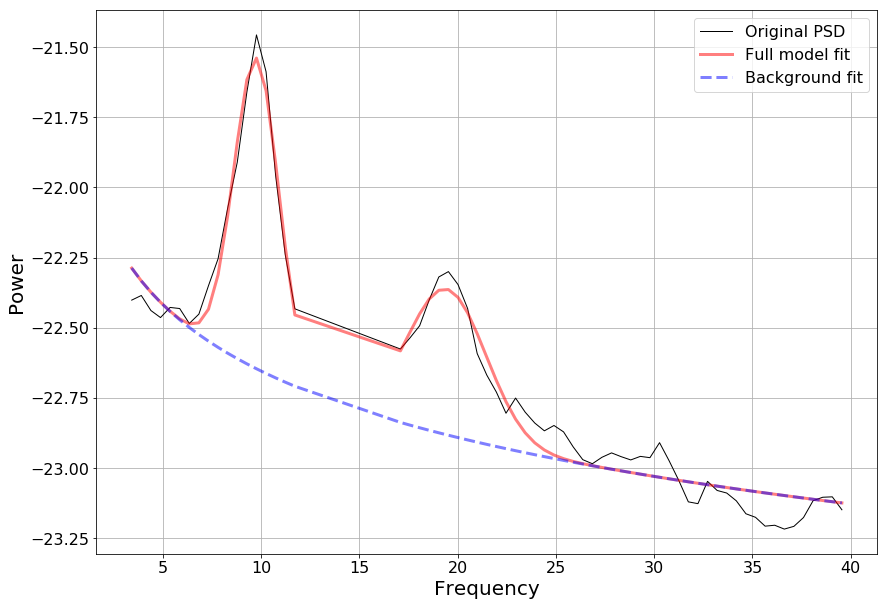

In [6]:
# Alternatively, just fit the model with FOOOF.fit() (and optionally ignore the frequencies between 12-17)
fm.fit(freqs, psd, freq_range, ignore_range=[[12,17]])

# After fitting (with .model() or .fit()), plotting and parameter fitting can be called independently:
fm.plot()
fm.print_params()

## FOOOF model description

Fitting the model with FOOOF.model( ) or FOOOF.fit( ) are equivalent, and call the same underlying fit procedure. 

In both cases, the PSD is fit as a combination of the background process (the 'slope' of the arythmic, background 1/f), upon which frequency regions of power over (which we consider to be oscillations). 

The background fit is 2nd order polynomial, fit on the semilog PSD (linear frequencies and log10 power values). Regions of power over above this background slope are fit in the model by a gaussian. The full PSD fit is the combination of the polynomial fit, and n gaussian processes, where 'n' is the number of 'oscillatory regions' found by the model.

Full method details available in the paper: [LINK WHEN AVAILABLE]

The model fit parameters are stored as object attributes that can be accessed after fitting.

In [7]:
# Background params 
print('Background Parameters: \n', fm.background_params, '\n')

# Oscillation parameters
print('Oscillation Parameters: \n', fm.oscillation_params, '\n')

Background Parameters: 
 [ -2.18676292e+01  -7.86841694e-01   1.31477598e-16] 

Oscillation Parameters: 
 [[  9.75907155   1.10709602   2.28336148]
 [ 19.46506548   0.51918698   3.98196494]] 



### Notes on Interpreting Oscillation Parameters

Note that the oscillation parameters that are returned are not exactly the same as the parameters of the gaussians used internally to fit the oscillations. 

Specifically:
- CF is the mean parameter of the gaussian
- Amp is the amplitude of the model fit above the background slope fit [1]
- BW is 2 * the standard deviation of the gaussian [2]

[1] Since the gaussians are fit together, the amplitude of the gaussians can only be interpreted with respect to all other oscillations, making gaussian amplitude uninterpretable in isolation.

[2] Standard deviation is '1 sided', returned BW is '2 sided'.

In [8]:
# Check the error of the model fit
print('Fit error: \n', fm.error)

Fit error: 
 0.0525522663391


### Note on Model Fit Error

FOOOF calculates the model fit error as the R^2 error between the full psd_fit and the original PSD, and these scores cna be used to assess how the model is performing.

Note, however, that FOOOF is NOT optimized to minimize this fit error at all costs. To do so typically results in fitting a large number of gaussian processes, in a way that overfits noise. The purpose of FOOOF is to measure PSD slope, and regions of oscillatory processes. As much as possible, FOOOF is tuned to only fit gaussians to regions in which there is power over and above the noise of the background process, in which an expert human rater would consider there to be an oscillatory 'bump'. 

Given this, while high R^2 error may indicate a poor model fit, very low R^2 error may also indicate a PSD that is overfit, in which case the oscillation parameters from the model may not accurately reflect oscillatory regions. 

In [9]:
# There is also convenience method to gather model results 
bg_params, osc_params, r2, fit_error = fm.get_params()

In [10]:
from fooof import FOOOF
from fooof.utils import trim_psd